# Questions

## Increase in surface salinity in the arctic, is there some kind of trend in obersved data? What about models?

## How well does models represent the changes in salinity, and can they be used as a good indication for the future?

## How does sea surface salinity affect the vertical ocean circulation? And is this influence impactfull?

## What can we say about the sea surface salinity in the future, and how will this affect the vertical circulation in the arctic?


The Arctic has a greater temperature increase than other parts of the world because of arctic amplification [reference]. 

In [1]:
import functions as f
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import s3fs
import cftime
import intake
import numpy as np
from joblib import Parallel, delayed
from pyproj import Transformer
from datetime import datetime
import s3fs
%load_ext autoreload
%autoreload 2
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))

# Satellite data regions

## Region 1

In [2]:
import time
path='escience2022/Antoine/ESA_SMOS_Arctic_Sea_Surface_Salinity/'
years = [2011,2012,2013,2014,2015,2016,2017,2018,2019]
start = time.time()
sat_data = f.collect_satellite_data(years, path)
print(time.time()-start)

225.639315366745


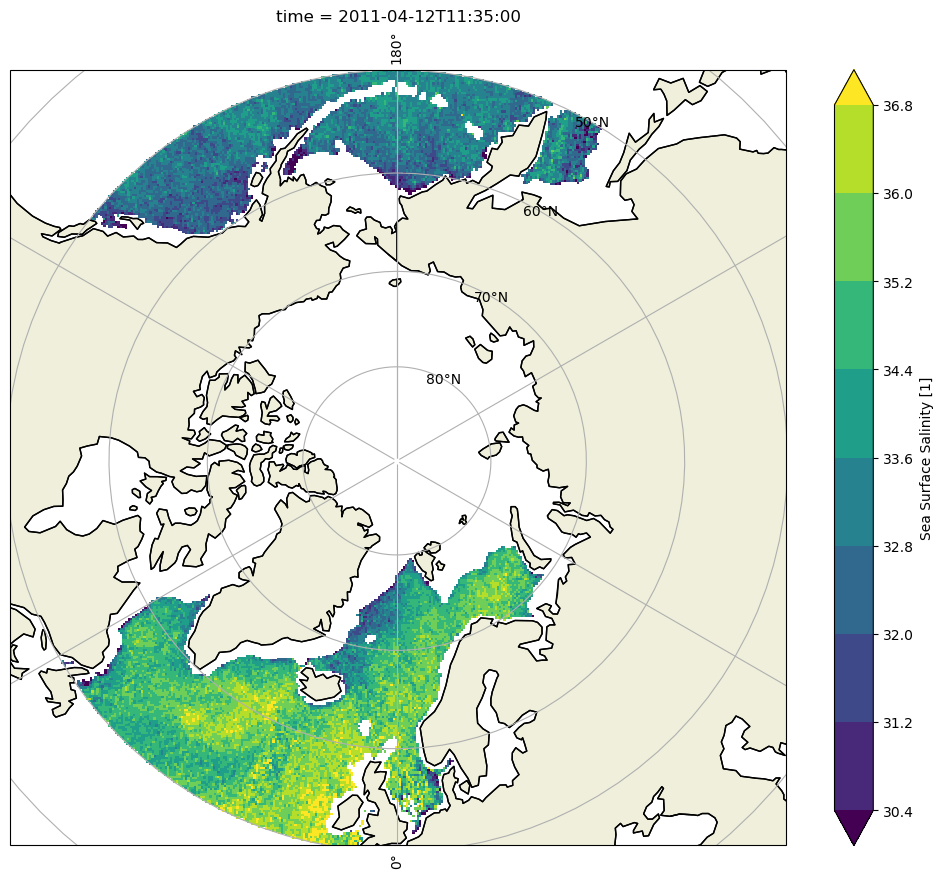

In [3]:
f.plot_sss_sat(sat_data['sss'][100])

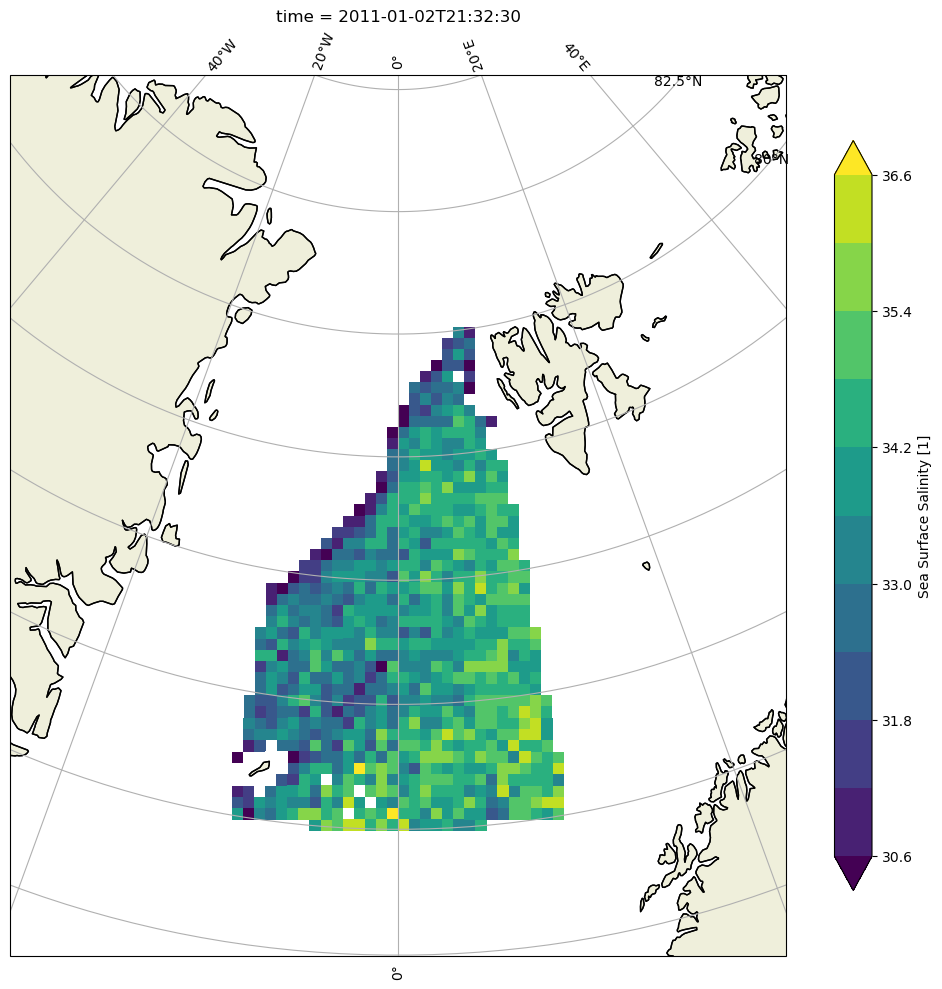

In [4]:
SatRegion1 = f.slice_data(sat_data, '2009-01-01', '2022-02-01', -10, 10, 70, 85)
f.plot_sss_sat(SatRegion1['sss'][0], extent = [-20,20,67,85])

## Region 2

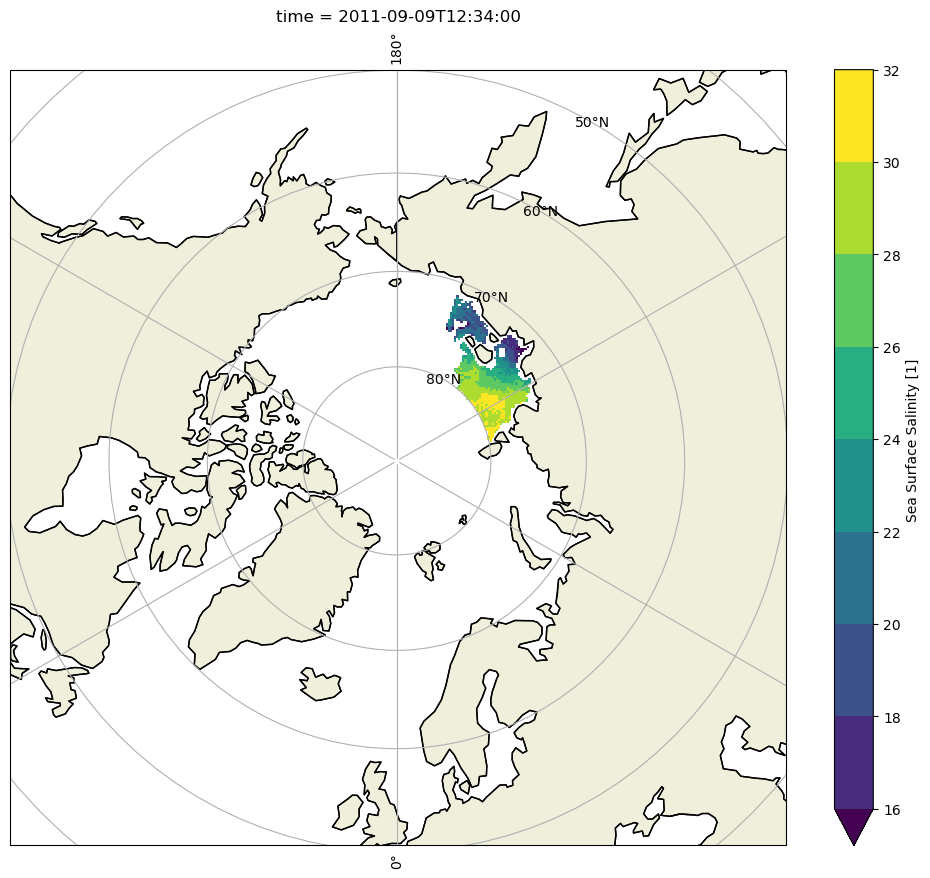

In [5]:
# Lon Lat [70-80, 100,160]
SatRegion2 = f.slice_data(sat_data, '2009-01-01', '2022-02-01', 100, 160, 70, 80)
f.plot_sss_sat(SatRegion2['sss'][250])#, extent = [-20,20,67,85])

# Seasonality

## Region 1

In [22]:
month = SatRegion1['time.month']
year = SatRegion1['time.year']
mean_list = []

## MAKE A STD HERE TOO
for y in [2012,2013,2014,2015,2016,2017,2018,2019]:
    for m in [1,2,3,4,5,6,7,8,9,10,11,12]:
        tmp = SatRegion1.where((month.isin(m)) & (year.isin(y))).mean('time')
        mean_list.append(tmp['sss'].mean())

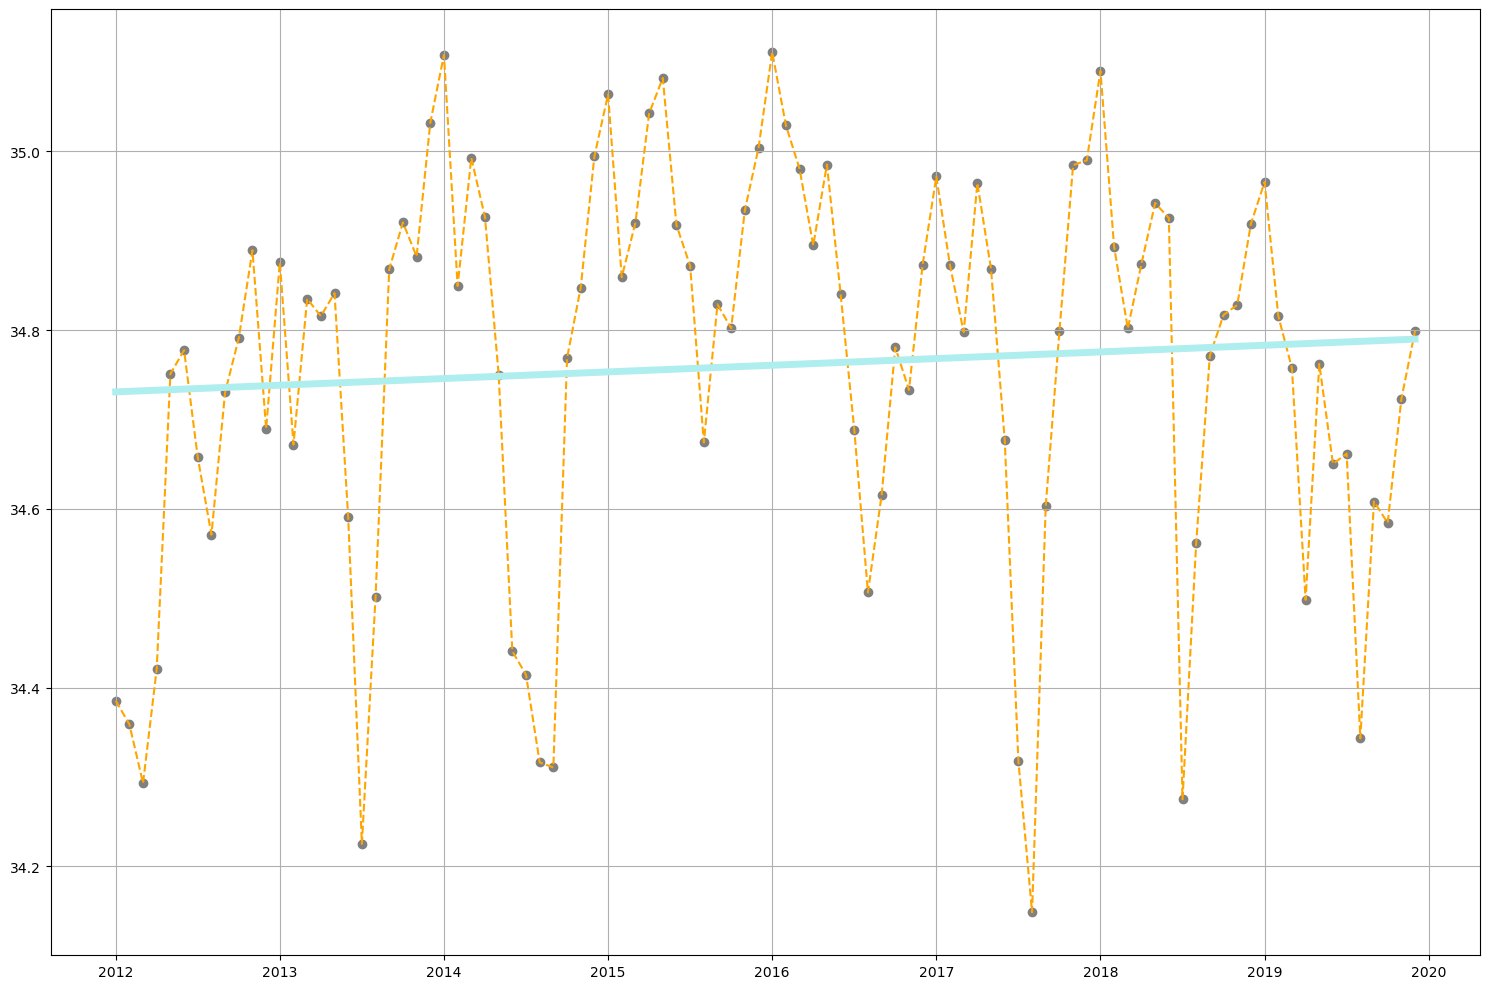

In [23]:
from scipy import stats
x = np.arange(0,12*8, 1)
ticks = [0,12,24,36,48,60,72,84,96]
dic = { 0:'2012', 12:'2013', 24:'2014', 36:'2015', 48:'2016', 60:'2017', 72:'2018', 84:'2019', 96:'2020'}
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]

res = stats.linregress(x, mean_list)
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(x, mean_list, '--', color='orange')
plt.scatter(x,mean_list, color='gray')
plt.plot(x, res.intercept + res.slope*x, color='paleturquoise', lw=5)
ax.set_xticks(ticks)

ax.set_xticklabels(labels)
plt.tight_layout()
plt.grid()
del(tmp)
del(res)
del(mean_list)

In [24]:
MeanSat = SatRegion1['sss'].groupby('time.dayofyear').mean(dim=['time', 'x', 'y']).compute()#.mean('x').mean('y').compute()
s = SatRegion1['sss'].mean(dim=['x','y']).compute().groupby('time.dayofyear')
StdSat = SatRegion1['sss'].groupby('time.dayofyear').std(dim=['time', 'x', 'y']).compute()

In [25]:
np.save('SeaSurfaceSalinitySatellitSeasonality.npy', MeanSat)

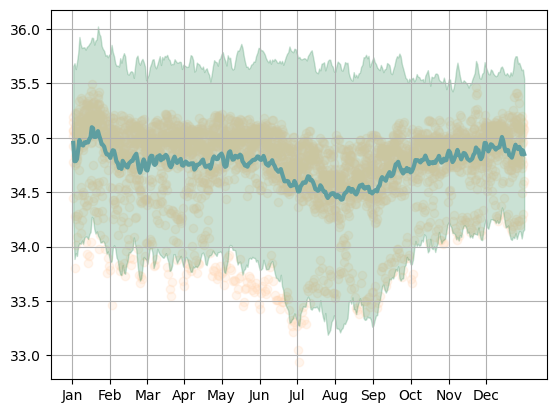

In [26]:
x = np.arange(1,367)

fig, ax = plt.subplots()
for month in s.groups.keys():
    m = np.full(len(s[month]), month)
    plt.scatter(m, s[month], color='peachpuff', alpha=0.25)
ax.fill_between(x, MeanSat-StdSat, MeanSat+StdSat, color='seagreen', alpha=0.25)

plt.plot(x, MeanSat, color='cadetblue', lw = 3)

dic = { 0:'Jan', 31:'Feb', 61:'Mar', 91:'Apr', 121:'May', 152:'Jun', 182:'Jul', 213:'Aug', 244:'Sep', 274:'Oct', 305:'Nov', 335:'Dec'}
ticks = [0,31,61,91,121,152,182,213,244,274,305,335]
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
plt.grid()
plt.show()

#We se a clear seasonal variation which follows the ice melt.
#Some variability during the season, mostly during the same time period as the ice melts. Different temperatures each year ----> different amount of fresh water flux from ice melt
#The std might not look good, but it is actually only 1-1.5. If we look at the bins below, we see that this spread can make sense

(array([1.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 7.000e+00, 8.000e+00,
        1.100e+01, 1.700e+01, 2.100e+01, 3.500e+01, 8.200e+01, 9.500e+01,
        1.800e+02, 2.910e+02, 6.310e+02, 1.629e+03, 2.711e+03, 1.372e+03,
        1.480e+02, 3.000e+00]),
 array([26.628506, 27.139326, 27.650148, 28.160969, 28.671791, 29.182611,
        29.693432, 30.204254, 30.715075, 31.225897, 31.736717, 32.24754 ,
        32.758358, 33.26918 , 33.780003, 34.290825, 34.801643, 35.312466,
        35.823288, 36.334106, 36.84493 ], dtype=float32),
 <BarContainer object of 20 artists>)

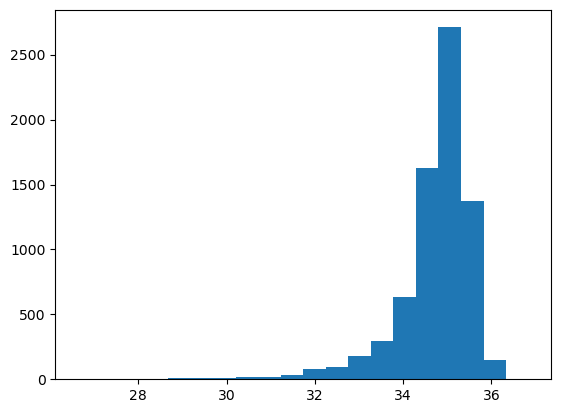

In [27]:
#plt.hist(SatRegion1['sss'].groupby('time.dayofyear')[100])
SatRegion1['sss'].groupby('time.dayofyear')[100].values.ravel()
plt.hist(SatRegion1['sss'].groupby('time.dayofyear')[100].values.ravel(), bins=20)

In [28]:
import datetime
years = np.arange(2011,2020,1)
days = np.arange(0,365,1)
dates = np.array([
    [datetime.datetime(y, 1,1) + datetime.timedelta(d) for d in range(365)] for y in years])

salinity_matrix = np.array([[
    SatRegion1['sss'].sel(time=dates[i,j], method='nearest').mean(dim=['x', 'y'])
                            for i in range(np.shape(dates)[0])] 
                                           for j in range(np.shape(dates)[1])])

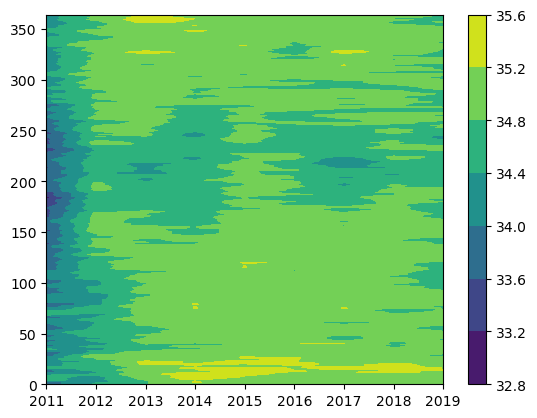

In [29]:
Y, D = np.meshgrid(years, days)
plt.contourf(Y, D, salinity_matrix)
plt.colorbar()

## Region 2

In [31]:
MeanSat2 = SatRegion2['sss'].groupby('time.dayofyear').mean(['time', 'x', 'y']).compute()
s2 = SatRegion2['sss'].mean(dim=['x', 'y']).compute().groupby('time.dayofyear')
StdSat2 = SatRegion2['sss'].groupby('time.dayofyear').std(dim=['time', 'x', 'y']).compute()

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


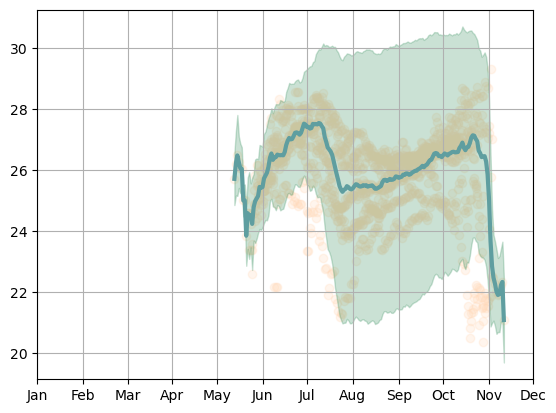

In [32]:
x = np.arange(1,367)

fig, ax = plt.subplots()
for month in s2.groups.keys():
    m = np.full(len(s2[month]), month)
    plt.scatter(m, s2[month], color='peachpuff', alpha=0.25)
ax.fill_between(x, MeanSat2-StdSat2, MeanSat2+StdSat2, color='seagreen', alpha=0.25)

plt.plot(x, MeanSat2, color='cadetblue', lw = 3)

dic = { 0:'Jan', 31:'Feb', 61:'Mar', 91:'Apr', 121:'May', 152:'Jun', 182:'Jul', 213:'Aug', 244:'Sep', 274:'Oct', 305:'Nov', 335:'Dec'}
ticks = [0,31,61,91,121,152,182,213,244,274,305,335]
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
plt.grid()
plt.show()


In [33]:
import datetime
years = np.arange(2011,2020,1)
days = np.arange(0,365,1)
dates = np.array([
    [datetime.datetime(y, 1,1) + datetime.timedelta(d) for d in range(365)] for y in years])

salinity_matrix2 = np.array([[
    SatRegion2['sss'].sel(time=dates[i,j], method='nearest').mean(dim=['x', 'y'])
                            for i in range(np.shape(dates)[0])] 
                                           for j in range(np.shape(dates)[1])])



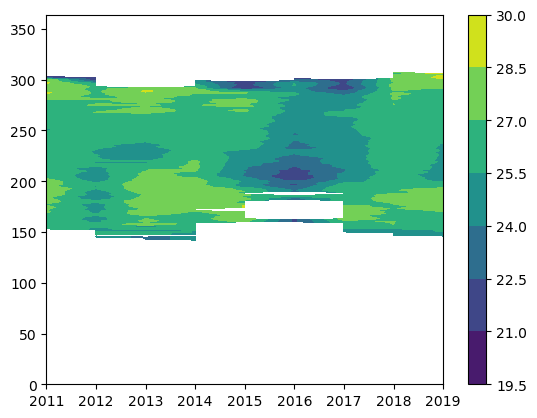

In [44]:


test = SatRegion2['sss'].mean(dim=['x', 'y']).values.reshape(365,9)
Y, D = np.meshgrid(years, days)
plt.contourf(Y, D, salinity_matrix2)
plt.colorbar()

## Correlation with ice concentration

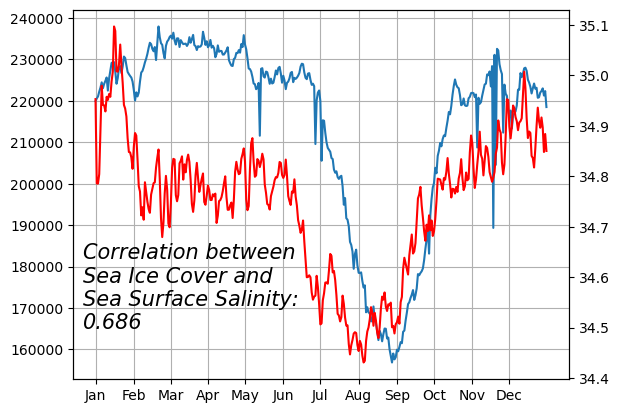

In [51]:
ice_path = 'AMSR2_E_Daily sea ice extent_GL sea.nc'
ice_ds = xr.open_dataset(ice_path)

MeanIceDaily = ice_ds['z'].groupby('time.dayofyear').mean('time').compute()
STDIceDaily = ice_ds['z'].groupby('time.dayofyear').std('time').compute()

x = np.arange(366)
fig, ax = plt.subplots()
ax1 = ax.twinx()
#ax.fill_between(x, MeanIceDaily+STDIceDaily, MeanIceDaily-STDIceDaily, color='seashell')
#ax1.fill_between(x, MeanSat-StdSat, MeanSat+StdSat, color='seashell')
ax.plot(x, MeanIceDaily)

ax1.plot(x, MeanSat, 'r')
dic = { 0:'Jan', 31:'Feb', 61:'Mar', 91:'Apr', 121:'May', 152:'Jun', 182:'Jul', 213:'Aug', 244:'Sep', 274:'Oct', 305:'Nov', 335:'Dec'}
ticks = [0,31,61,91,121,152,182,213,244,274,305,335]
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
corr = np.corrcoef(MeanIceDaily, MeanSat)[0,1]
ax.text(-10, 165000, f'Correlation between \nSea Ice Cover and \nSea Surface Salinity:\n{corr:.3f}', style ='italic',
        fontsize = 15, color ="black")
ax.grid()
plt.show()
#SeaIceCover
#When Sea Ice melts, it will become thinner in the beginning, but will still cover the ocean
#this means that while the sea ice extent does not get much smaller, it becomes thinner, so we have a freshwater input into the ocean, meaning that salinity should decrease

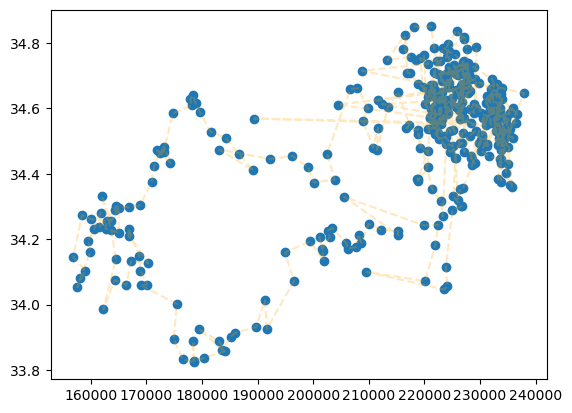

In [10]:
plt.scatter(MeanIceDaily, MeanSat)
plt.plot(MeanIceDaily, MeanSat, '--', color='orange', alpha=0.25)

#Circular means lag in the signal, one that increases and then second one increases

In [ ]:
del(MeanIceDaily)
del(STDIceDaily)
del(corr)

## Region 2

# ARGO data

In [43]:
_id = '3901591'
_id2 = '3901620'
argo_path = f's3://escience2022/Ada/ARGO/coriolis/{_id}/{_id}_prof.nc'
argo_path2 = f's3://escience2022/Ada/ARGO/coriolis/{_id2}/{_id2}_prof.nc'

In [45]:
Argo1 = xr.open_dataset(s3.open(argo_path))
Argo2 = xr.open_dataset(s3.open(argo_path2))

In [46]:
Argo1.JULD

<xarray.DataArray 'JULD' (N_PROF: 65)>
array(['2016-08-24T00:35:18.000002816', '2016-09-03T00:36:53.999995136',
       '2016-09-12T22:51:59.000001536', '2016-09-22T23:08:11.000000000',
       '2016-10-03T00:35:46.999996416', '2016-10-12T23:01:21.999995392',
       '2016-10-23T00:36:40.000000768', '2016-11-01T23:07:09.999998976',
       '2016-11-12T00:35:27.000004352', '2016-11-21T23:03:51.000002048',
       '2016-12-02T00:34:56.999996160', '2016-12-11T23:16:37.999995904',
       '2016-12-22T00:43:31.999998976', '2016-12-31T22:58:38.000000000',
       '2017-01-11T00:39:30.999998464', '2017-01-20T22:56:00.000002048',
       '2017-01-31T00:43:54.000000256', '2017-02-09T23:03:10.999997696',
       '2017-02-20T00:41:59.000000512', '2017-03-01T22:53:33.999999232',
       '2017-03-12T00:36:34.000003072', '2017-03-21T23:07:46.000004864',
       '2017-04-10T22:18:56.999999744', '2017-04-20T22:09:57.000001792',
       '2017-05-10T22:12:55.999996416', '2017-05-20T22:27:02.000004352',
       '2017-05-30T22:13:06.999996928', '2017-06-09T22:18:49.000002816',
       '2017-06-19T22:15:23.999998208', '2017-06-29T22:12:42.000001792',
       '2017-07-09T22:27:30.000003328', '2017-07-19T22:28:59.000003328',
       '2017-07-29T22:42:22.999997696', '2017-08-08T22:53:39.999996928',
       '2017-08-18T22:53:46.000004608', '2017-08-28T23:09:15.999999488',
       '2017-09-07T23:05:51.000004864', '2017-09-17T23:21:20.999999744',
       '2017-09-28T00:51:45.000000256', '2017-10-07T23:23:38.000001024',
       '2017-10-18T00:44:14.000002560', '2017-10-27T23:09:06.999997952',
       '2017-11-07T00:41:36.999998976', '2017-11-16T23:16:18.999998464',
       '2017-11-27T00:39:41.999999232', '2017-12-06T23:39:36.000004864',
       '2017-12-17T00:41:59.000000512', '2017-12-26T23:25:05.000001792',
       '2018-01-06T00:49:53.000004352', '2018-01-15T23:11:57.999995904',
       '2018-01-26T00:44:27.999996928', '2018-02-04T23:06:32.999998464',
       '2018-02-15T00:43:57.000004096', '2018-02-24T23:03:14.999996160',
       '2018-03-07T00:45:32.000001792', '2018-03-16T23:05:31.999997440',
       '2018-03-27T00:40:07.000004352', '2018-04-05T23:09:54.999999232',
       '2018-04-16T00:41:01.000003328', '2018-04-25T23:03:06.000004608',
       '2018-05-06T00:42:36.000001024', '2018-05-15T22:56:59.999998464',
       '2018-05-26T00:44:10.999998720', '2018-06-04T23:25:53.000003072',
       '2018-06-15T00:47:51.999996928'], dtype='datetime64[ns]')
Dimensions without coordinates: N_PROF
Attributes:
    long_name:      Julian day (UTC) of the station relative to REFERENCE_DAT...
    standard_name:  time
    conventions:    Relative julian days with decimal part (as parts of day)
    resolution:     1.1574074074074073e-05
    axis:           T

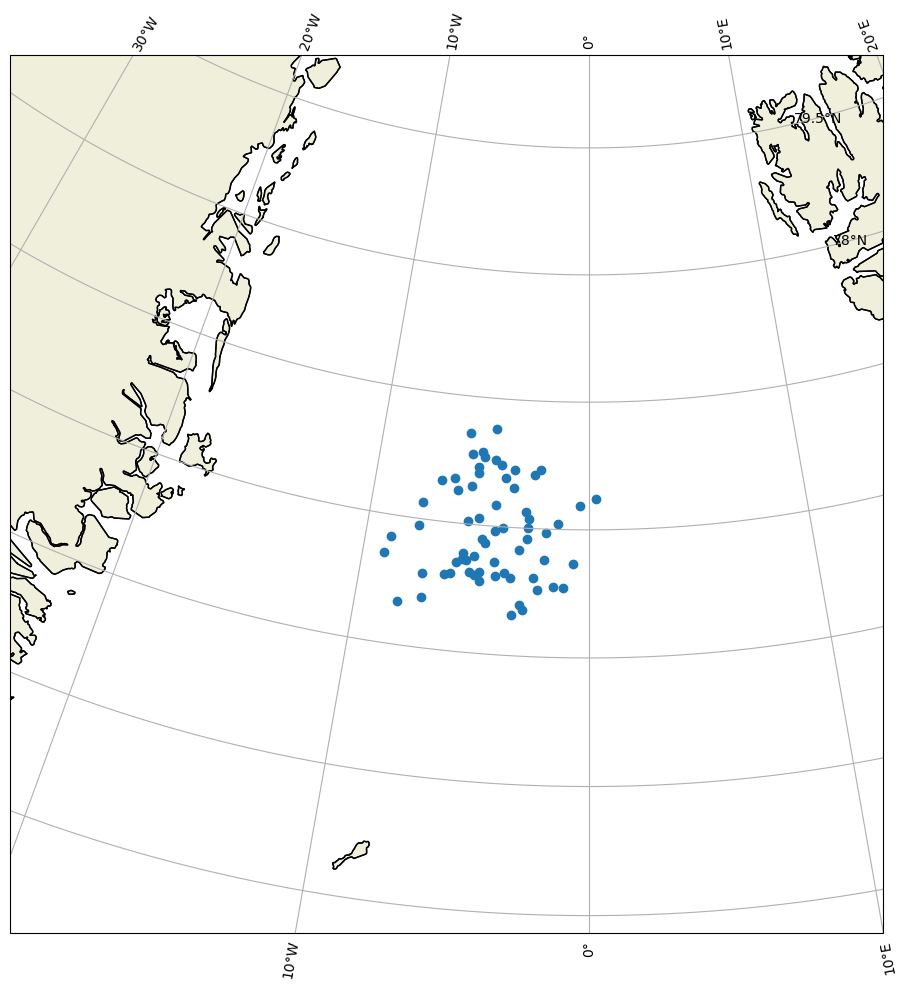

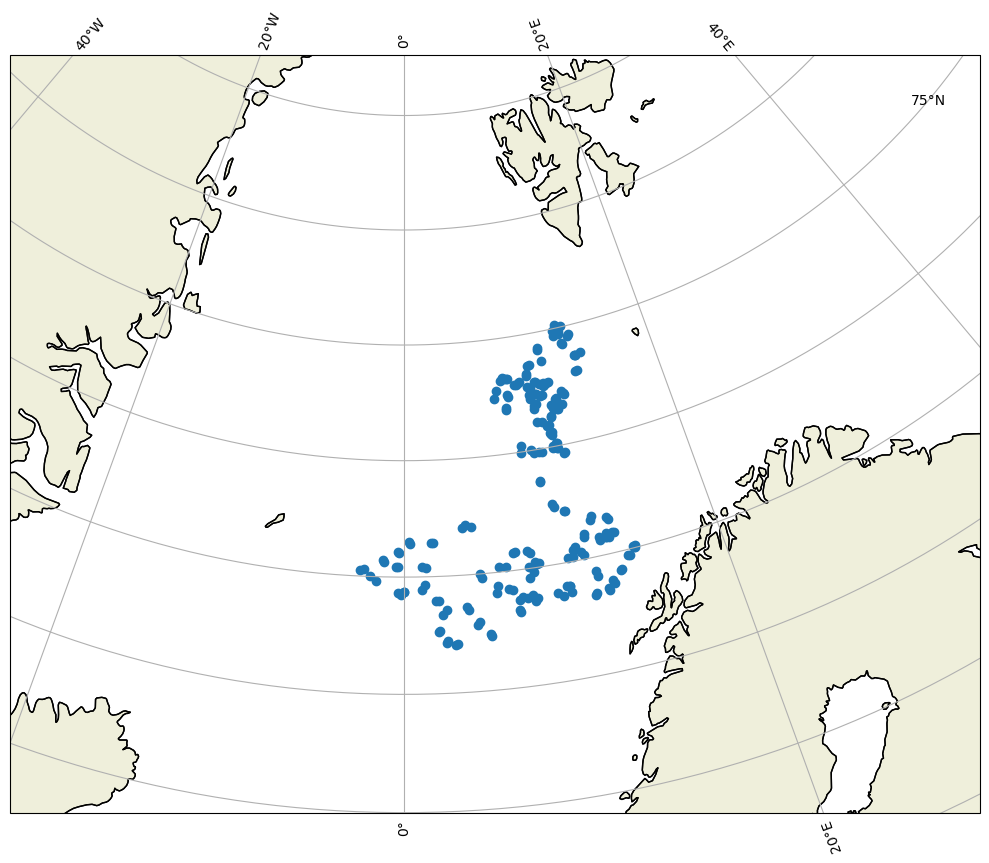

In [48]:
f.plot_argo_positions(Argo1, extent=[-20,10,80,70])
f.plot_argo_positions(Argo2, extent=[-20,30,80,65])

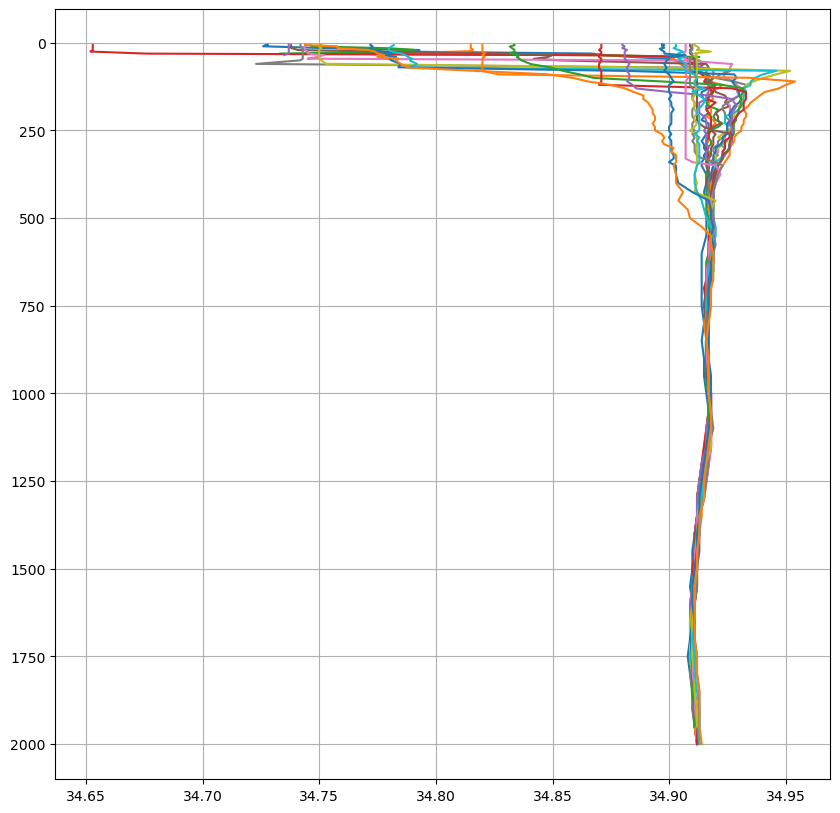

In [49]:
fig, ax = plt.subplots(figsize=(10,10))
for i in range(30):
    plt.plot(Argo1['PSAL_ADJUSTED'][i], Argo1['PRES'][i])
    #plt.plot(Argo2['PSAL_ADJUSTED'][i], Argo2['PRES'][i])
plt.gca().invert_yaxis()
ax.grid()

# Model data

## Region 1

In [2]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(variable_id='so', source_id='UKESM1-0-LL', activity_id='CMIP', experiment_id='historical')
cat2 = col.search(variable_id='areacello', source_id='UKESM1-0-LL')

In [3]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dset_dict2 = cat2.to_dataset_dict(zarr_kwargs={'use_cftime':True})
MDS = dset_dict[list(dset_dict.keys())[1]]
ModelDataList2 = list(dset_dict2.keys())
MDS = MDS.mean('member_id', keep_attrs=True)
areacello = dset_dict2[ModelDataList2[0]].squeeze()

del(dset_dict)
del(dset_dict2)
del(ModelDataList2)
#mds = MDS.sel(time='2010-10').sel(bnds=0).sel(lev=1, method='nearest').sel(vertices=0).squeeze()
#mds = f.slice_data(mds, min_lon = -10, max_lon=10, min_lat = 70, max_lat = 85)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [4]:
MReg = MDS.sel(time = slice('1980','2010')).sel(lev=0, method='nearest').sel(bnds=0).sel(vertices=0)
MReg = f.slice_data(MReg, min_lat = 70, max_lat = 85, min_lon = -10, max_lon = 10)
#area = area.where(area['latitude']-(area['longitude']/2) > min(min_lat-min_lon/2-1, max_lat-max_lon/2-1), drop=True)

In [5]:
ac=areacello.where(
    (areacello['longitude'] > -10)
    & (areacello['longitude'] < 10)
    & (areacello['latitude'] > 70)
    & (areacello['latitude'] < 85),
    drop=True
    )

In [6]:
#-10, 10, 70, 85
def WeightedMean(ds,ac):
    RegionMean = ((ds * ac['areacello']).sum(dim=['i','j'])/ac['areacello'].sum()).compute()
    return RegionMean
#RegionStd = (MReg - RegionMean).sum(dim=['i', 'j']).compute()
#mean = 1/np.sum(areacello['areacello'])*np.sum()

In [ ]:
MReg = WeightedMean(MReg, ac)

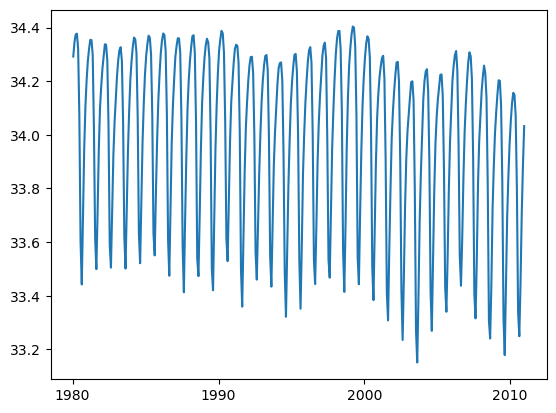

In [26]:
#mean.plot.scatter(x ='time')
plt.plot(MReg.time, MReg.so)
#plt.plot(RegionMean.time, RegionStd.so)

In [27]:
MonthlyMean = MReg.groupby('time.month').mean('time')
SatMean = np.load('SeaSurfaceSalinitySatellitSeasonality.npy')

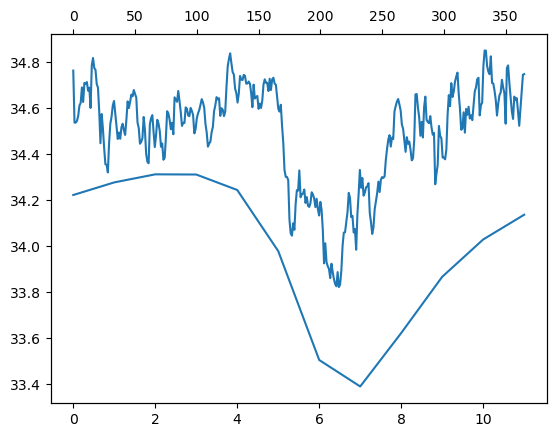

In [28]:
x = np.arange(12)
y = np.arange(len(SatMean))
fig, ax = plt.subplots()
ax.plot(x, MonthlyMean['so'])
ax2 = ax.twiny()
ax2.plot(y, SatMean)
plt.show()


In [38]:
MRegDepth = MDS.sel(time = slice('1980','2010')).sel(lev=200, method='nearest').sel(bnds=0).sel(vertices=0)
MRegDepth = f.slice_data(MRegDepth, min_lat = 70, max_lat = 85, min_lon = -10, max_lon = 10)

MRegDepth = WeightedMean(MRegDepth, ac)

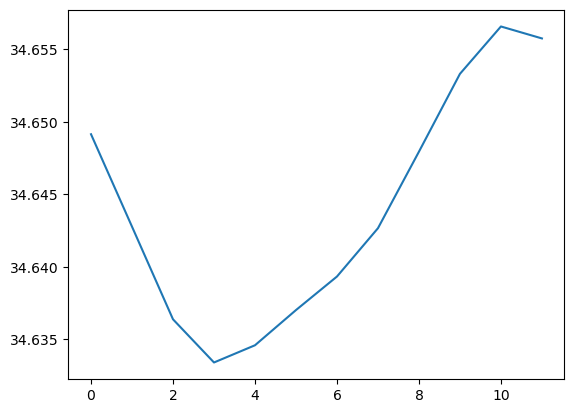

In [39]:
MRegDepth
MonthlyMeanDepth = MRegDepth.groupby('time.month').mean('time')
x = np.arange(12)
plt.plot(x, MonthlyMeanDepth.so)

In [ ]:
# Do a weighted mean with areacello
f.PlotModel(MDS.sel(time = '2010-01').sel(lev=0, method='nearest').sel(bnds=0).sel(vertices=0).squeeze())
#f.PlotSeasonality(MDS.sel(time = slice('1980','2020')).sel(lev=0, method='nearest').sel(bnds=0).sel(vertices=0))
f.PlotSeasonality(MDS.sel(time = slice('1980','2020')).sel(lev=200, method='nearest').sel(bnds=0).sel(vertices=0))


In [41]:

#-10, 10, 70, 85

last30 = MDS.sel(time=slice('1980', '2010')).sel(lev=0, method='nearest').sel(bnds=0).sel(vertices=0)
clm = MDS.sel(time=slice('1850', '1880')).sel(lev=0, method='nearest').sel(bnds=0).sel(vertices=0)

last30 = f.slice_data(last30, min_lon = -10, max_lon = 10, min_lat = 70, max_lat = 85)
clm = f.slice_data(clm,  min_lon = -10, max_lon = 10, min_lat = 70, max_lat = 85)

last30 = last30.mean('time').compute()
clm = clm.mean('time').compute()

KeyboardInterrupt: 

In [ ]:
anomaly=last30-clm
last30
f.PlotModel(anomaly, extent=[-22,12,60,85])

In [ ]:
ts = area['so'].mean('i').mean('j').compute().groupby('time.year')

In [ ]:
yearly_mean = ts.mean('time')
yearly_mean

In [ ]:
x = np.arange(len(yearly_mean))
print(x)
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(x,yearly_mean)
res = stats.linregress(x,yearly_mean)
plt.plot(x, res.intercept + res.slope*x)

# Region 2

In [7]:
MReg2 = MDS.sel(time = slice('1980','2010')).sel(lev=0, method='nearest').sel(bnds=0).sel(vertices=0)
MReg2 = f.slice_data(MReg2, min_lat = 70, max_lat = 80, min_lon = 100, max_lon = 160)

In [8]:
MReg2.sel(time='2010-01')

<xarray.Dataset>
Dimensions:             (time: 1, j: 30, i: 37)
Coordinates:
  * i                   (i) int32 56 57 58 59 60 61 62 ... 86 87 88 89 90 91 92
  * j                   (j) int32 290 291 292 293 294 ... 315 316 317 318 319
    latitude            (j, i) float32 dask.array<chunksize=(30, 37), meta=np.ndarray>
    lev                 float64 0.5058
    lev_bnds            float64 dask.array<chunksize=(), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(30, 37), meta=np.ndarray>
  * time                (time) object 2010-01-16 00:00:00
    time_bnds           (time) object dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    so                  (time, j, i) float32 dask.array<chunksize=(1, 30, 37), meta=np.ndarray>
    vertices_latitude   (j, i) float32 dask.array<chunksize=(30, 37), meta=np.ndarray>
    vertices_longitude  (j, i) float32 dask.array<chunksize=(30, 37), meta=np.ndarray>
Attributes: (12/43)
    cmor_version:            3.4.0
    table_info:              Creation Date:(13 December 2018) MD5:f0588f7f55b...
    variable_name:           so
    parent_variant_label:    r1i1p1f2
    institution_id:          MOHC
    status:                  2020-12-03;created; by gcs.cmip6.ldeo@gmail.com
    ...                      ...
    physics_index:           1
    license:                 CMIP6 model data produced by the Met Office Hadl...
    history:                 2019-06-03T15:19:35Z ; CMOR rewrote data to be c...
    parent_time_units:       days since 1850-01-01
    branch_method:           standard
    intake_esm_dataset_key:  CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn

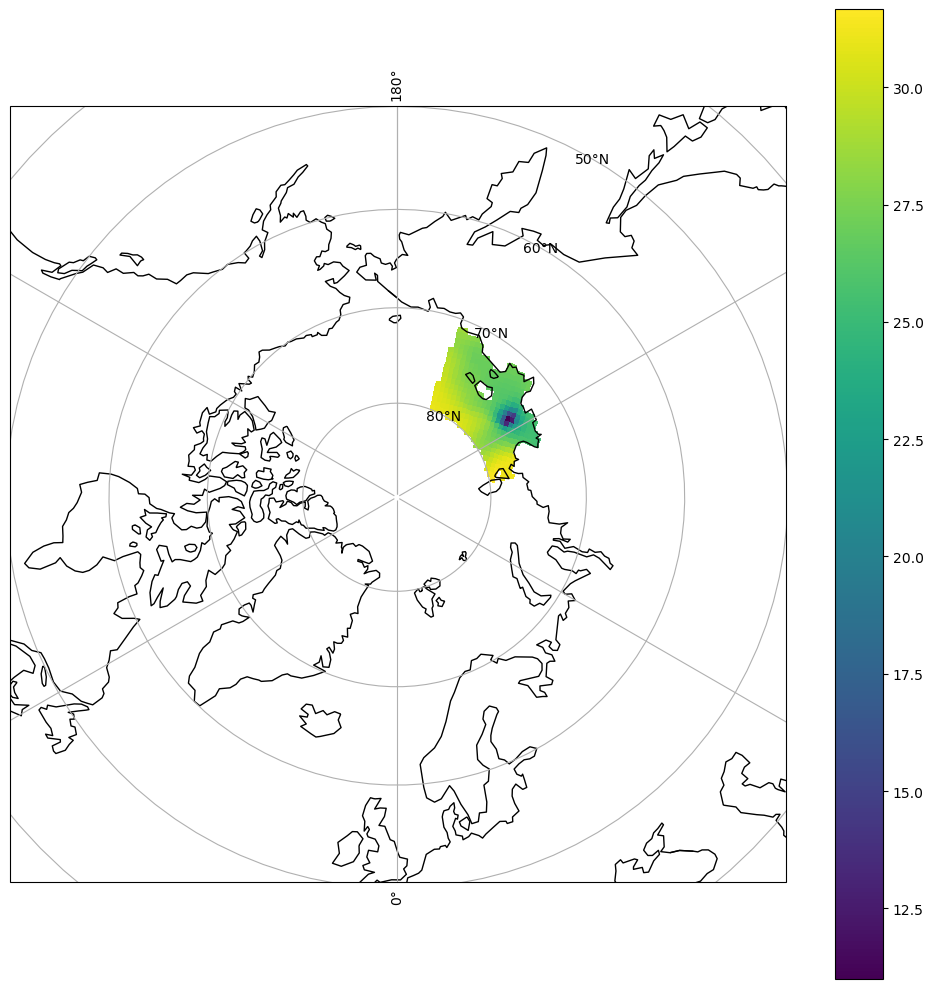

In [9]:
f.PlotModel(MReg2.sel(time='2010-01').squeeze())

In [10]:
ac2=areacello.where(
    (areacello['longitude'] > 100)
    & (areacello['longitude'] < 160)
    & (areacello['latitude'] > 70)
    & (areacello['latitude'] < 80),
    drop=True
    )

In [11]:
MReg2 = WeightedMean(MReg2, ac2)

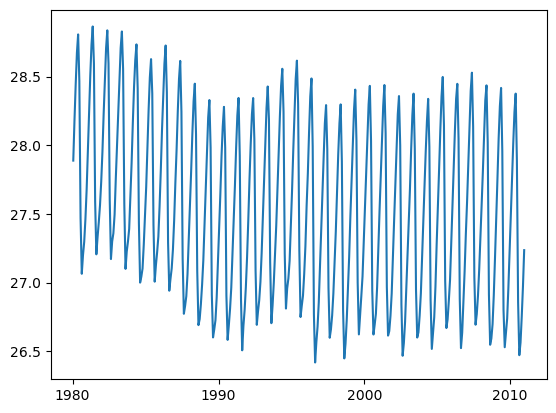

In [12]:
plt.plot(MReg2.time, MReg2.so)

In [ ]:
MonthlyMean2 = MReg2.groupby('time.month').mean('time')

In [ ]:
x = np.arange(12)
#y = np.arange(len(SatMean))
fig, ax = plt.subplots()
ax.plot(x, MonthlyMean2['so'])

In [24]:
import datetime
from dateutil.relativedelta import relativedelta
#'1980','2010'
years = np.arange(1980,2011,1)
months = np.arange(0,12,1)
dates = np.array([
    [datetime.datetime(y, 1,1) + relativedelta(months=m) for m in range(12)] for y in years])


"""
salinity_matrix = np.array([[
    MReg2['so'].sel(time=dates[i,j], method='nearest').mean(dim=['i', 'j'])
                            for i in range(np.shape(dates)[0])] 
                                           for j in range(np.shape(dates)[1])])
"""

"\nsalinity_matrix = np.array([[\n    MReg2['so'].sel(time=dates[i,j], method='nearest').mean(dim=['i', 'j'])\n                            for i in range(np.shape(dates)[0])] \n                                           for j in range(np.shape(dates)[1])])\n"

## Vertical Structure Model

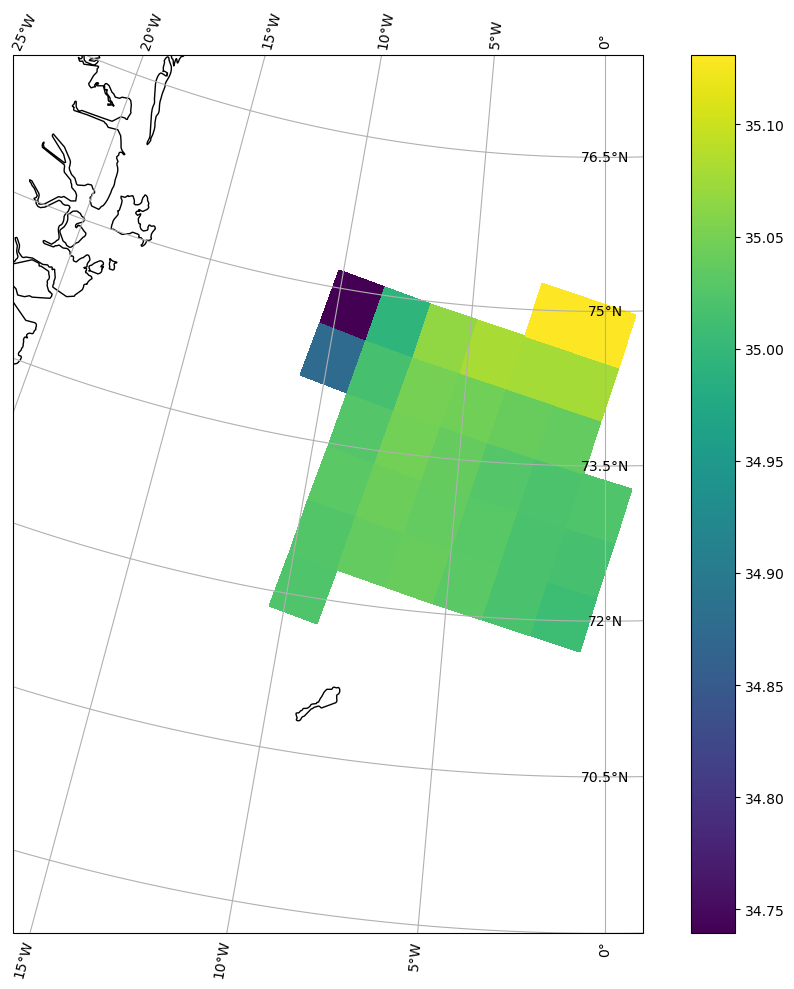

In [78]:
MDS
Vertical=MDS.sel(time=slice('2000', '2010')).sel(bnds=1).sel(vertices=0).squeeze()
#print(Vertical)
#Vertical = Vertical.sel(longitude=-3, method='nearest')
#Vertical = f.ConvertModelGrid(Vertical)
Vertical = Vertical.where(
    (Vertical['longitude'] < 0)
    & (Vertical['longitude'] > -10)
    & (Vertical['latitude'] < 75)
    & (Vertical['latitude'] > 72),
    drop=True)

f.PlotModel(Vertical.sel(lev=0, method='nearest').isel(time=0), extent=[-16,1,69,77])
#Mean vertical structure over an area

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


KeyboardInterrupt: 

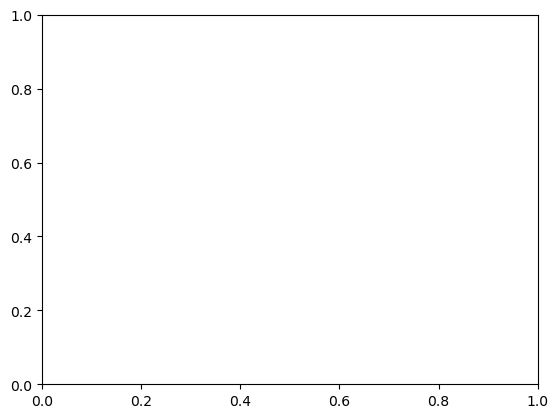

In [82]:
Vertical2 = Vertical.isel(lev=slice(0,60))
mean_structure=Vertical2['so'].mean('i').mean('j').mean('time')
std_structure=Vertical2['so'].std('i').std('j').mean('time')
fig, ax = plt.subplots()
ax.fill_between(Vertical2.lev, mean_structure-std_structure, mean_structure+std_structure)
plt.plot(mean_structure, Vertical2['lev'])
#plt.plot(mean_structure-std_structure, Vertical2['lev'], color='orange')
#plt.plot(mean_structure+std_structure, Vertical2['lev'], color='orange')
ax.invert_yaxis()
for i in range(len(Argo1['PSAL_ADJUSTED'])):
    plt.plot(Argo1['PSAL_ADJUSTED'][i], Argo1['PRES'][i])

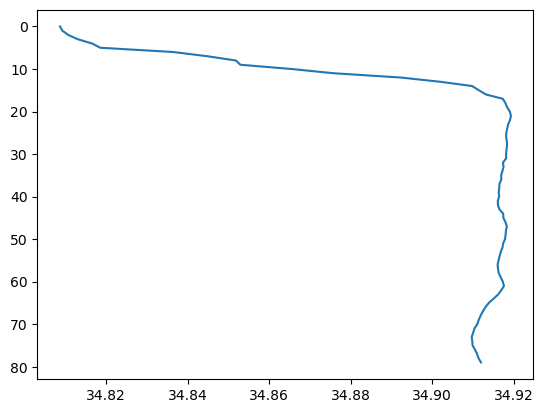

In [80]:
Argo1.JULD
profiles = Argo1.PSAL_ADJUSTED
depth = Argo1.PRES
profiles=profiles.mean('N_PROF')
fig, ax = plt.subplots()
plt.plot(profiles, np.arange(len(profiles)))
ax.invert_yaxis()

In [ ]:
Vertical2 = Vertical.isel(lev=slice(10,60))
mean_structure=Vertical2['so'].mean('i').mean('j').mean('time')
std_structure=Vertical2['so'].std('i').std('j').mean('time')
fig, ax = plt.subplots()
plt.plot(mean_structure, Vertical2['lev'])
plt.plot(mean_structure-std_structure, Vertical2['lev'], color='orange')
plt.plot(mean_structure+std_structure, Vertical2['lev'], color='orange')
ax.invert_yaxis()
for i in range(len(Argo1['PSAL_ADJUSTED'])):
    plt.plot(Argo1['PSAL_ADJUSTED'][i][10:], Argo1['PRES'][i][10:])